In [79]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy as sp
import os

plt.style.use('seaborn-v0_8')

In [80]:
# relavant physical constants

mu_B = 9.274*10**-24
h_bar = 1.054*10**-34
h = h_bar*2*np.pi
c= 299792458

In [ ]:
# import all data 
mercury_data = pd.DataFrame({
        'wavelength': [], 
        'polarization': [], 
        'b-field': [], 
        'data': []
    }
).astype({'data':'object'})

mercury_data.set_index(['wavelength', 'polarization', 'b-field'], inplace=True)

mercury_dir = './data/mercury'  
neon_dir = './data/neon'

# upload everything into the dataframe

for file in os.listdir(mercury_dir):
    filename = os.fsdecode(file)
    key = tuple(filename.replace('.tsv', '').split("_"))
    
    data_to_store = pd.read_csv(os.path.join(mercury_dir, filename), sep = '\t', names = ['wavelength', 'counts'])
    mercury_data.loc[key, 'data']=[data_to_store]
    

for file in os.listdir(neon_dir):
    filename = os.fsdecode(file)
    key = tuple(filename.replace('.tsv', '').split("_"))
    
    data_to_store = pd.read_csv(os.path.join(neon_dir, filename), sep = '\t', names = ['wavelength', 'counts'])
    mercury_data.loc[key, 'data']=[data_to_store]
    


print(mercury_data.loc[('404.7nm', '024deg', '0.9T'), 'data'])

FileNotFoundError: [Errno 2] No such file or directory: './data/mercury\\585.3nm_024deg_0.0T.tsv'

('404.7nm', '024deg')
Theorized resolution: 0.021071676970898817
[4.05150496e+02 4.44015570e-04]
('404.7nm', '114deg')
Theorized resolution: 0.02206267782654958
[4.05150053e+02 4.86761753e-04]
('435.8nm', '024deg')
Theorized resolution: 0.019717796064586224
[4.36323364e+02 3.88791482e-04]
('435.8nm', '114deg')
Theorized resolution: 0.025021657910844534
[4.36323380e+02 6.26083365e-04]
('546.1nm', '024deg')
Theorized resolution: 0.00616959740167429
[5.46591001e+02 3.80639321e-05]
('546.1nm', '114deg')
Theorized resolution: 0.004247068366108507
[5.46591000e+02 1.80375897e-05]


C:\Users\Ali\AppData\Local\Temp\ipykernel_10352\1513025337.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  param1, param2 = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [float(index[0].replace("nm", "")), 0.1] )


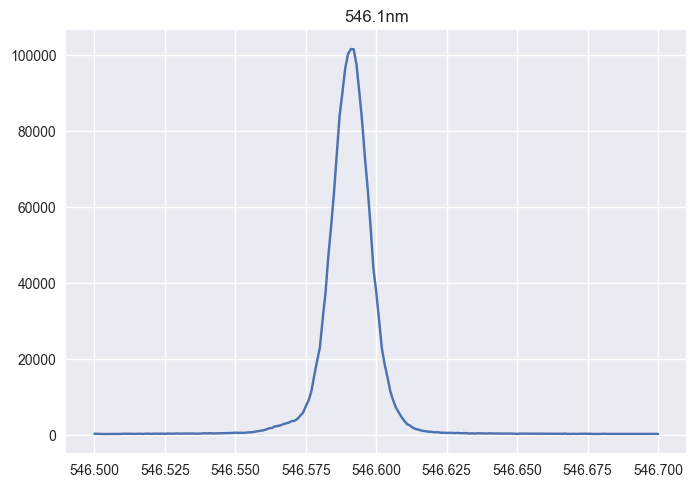

In [82]:
# example of choosing a datapoint

chosen_data = mercury_data.loc[("546.1nm", "024deg", "1.4T"), 'data'][0]

# example of filtering based off of a certain metric 

all_114 = mercury_data.xs('0.0T', level='b-field')


# Fit all data to get its half-width with a gaussian distribution, see if the resolution is the same across the board

for index, row in all_114.iterrows(): 
    xdata = row["data"][0]["wavelength"].tolist()    
    ydata = row["data"][0]["counts"].tolist()
    print(index)
    param1, param2 = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [float(index[0].replace("nm", "")), 0.1] )
    print(f"Theorized resolution: {np.sqrt(param1[1])}")
    if(index[0]=='546.1nm' and index[1]=='114deg'):
        plt.plot(xdata,ydata)
    plt.title('546.1nm')
    print(param1)    

plt.show()

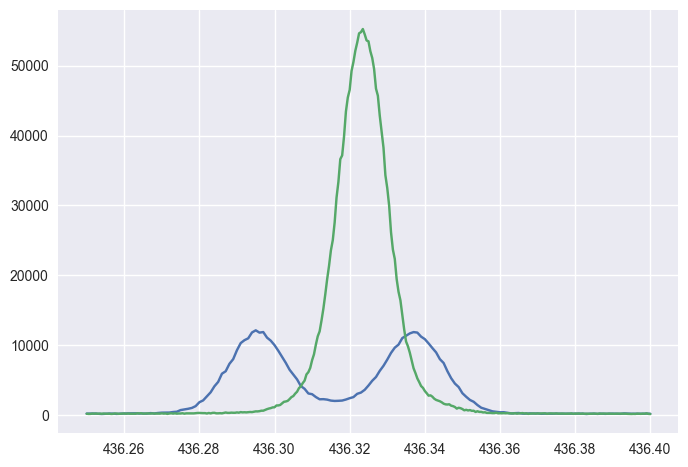

In [83]:
# plot the 0T vs 1.5T of the 435.8nm line

# think about the π lines, which have Δm = 0


line435 = mercury_data.xs("435.8nm", level='wavelength').xs("024deg", level="polarization")

high_field = line435.loc[("1.4T"), 'data'][0]
no_field = line435.loc[("0.0T"), 'data'][0]

plt.plot(high_field["wavelength"], high_field["counts"])
plt.plot(no_field["wavelength"], no_field["counts"])

In [299]:
from scipy.signal import argrelextrema, find_peaks

three_P_two = (2,1,1)


def provide_allowable_transitions(sigma_or_pi, Ji,Jf):
    ret_list = []
    
    start = np.arange(-Ji, Ji+1)
    end = np.arange(-Jf, Jf+1)

    if sigma_or_pi == "pi":
        # calculate list of levels
        for level in start:
            if level in end:
                ret_list.append((level, level))
        return ret_list
    elif sigma_or_pi == "sigma":
        for level in start:
            if (level+1) in end: 
                ret_list.append((level, level+1))
            if (level-1) in end:
                ret_list.append((level, level-1))
        return ret_list
    else:
        return -1

# Define transition numbers (J, S, L)

def g_lande(state):
    # unpack state
    J, L, S = state
    
    return 1+(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1))

def g_eff(statei, statef, transition):
    mi, mf = transition
    return g_lande(statef)*mf - g_lande(statei)*mi


def lambda_shift(wavelength, g_eff, b_field):
    return g_eff*wavelength**2*mu_B/h/c*b_field

def intensity_plot(wavelength, delta_wavelength, wavelength_0):
    return 1/np.pi/delta_wavelength*(1/(1+(wavelength-wavelength_0)**2/delta_wavelength**2))


def generate_plot(xdata, ydata, statei, statef, wavelength, b_field, type, resolution, offset = 0):
    
    current_width = 1
    exp_wavelength = 0
    
    peaks = find_peaks(np.array(ydata), width=current_width)[0]
    
    while(len(peaks)>2):
        current_width = current_width+1
        print(peaks)
        peaks = find_peaks(np.array(ydata), width=current_width)[0]
    if(len(peaks)==2):
        peak_wavelengths = xdata[peaks]
        exp_wavelength = np.mean(peak_wavelengths)
    elif(len(peaks)==1):
        exp_wavelength = xdata[peaks]
    else:
        fit, sigma = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [wavelength, 0.1] )
        exp_wavelength = fit
    print(peaks)
    print(exp_wavelength)
    norm = np.max(ydata)
    transitions = provide_allowable_transitions(sigma_or_pi=type, Ji = statei[0], Jf=statef[0])
    yrange = np.zeros(len(xdata))
    for transition in transitions:
        geff_value = g_eff(statei,statef,transition)
        shift = lambda_shift(exp_wavelength*10**-9, geff_value*10**9, b_field)
        to_add =  [intensity_plot(x,resolution, exp_wavelength+shift+offset) for x in xdata]
        if statef == three_P_two:
            if np.abs(geff_value)==1:
                to_add = np.array(to_add)*12
            if np.abs(geff_value)==3/2:
                to_add = np.array(to_add)*6
            if np.abs(geff_value)==2:
                to_add = np.array(to_add)*2
        yrange = yrange+to_add
    scaling_ratio = norm/np.max(yrange)
    yrange = scaling_ratio*yrange*0.95
    return xdata, yrange

In [300]:
provide_allowable_transitions("pi", 1, 1)

# Now calculate, the wavelength shift expected for each transition using the Landé g-factor


three_S_one = (1, 0, 1)
three_P_one = (1,1,1)

transitions= provide_allowable_transitions("sigma", three_S_one[0], three_P_one[0])

for transition in transitions:
    print(f'Transition of {transition}: geff = {g_eff(three_S_one, three_P_one, transition)}')
    
# Routine to fit against a given plot
    


Transition of (-1, 0): geff = 2.0
Transition of (0, 1): geff = 1.5
Transition of (0, -1): geff = -1.5
Transition of (1, 0): geff = -2.0


[(-1, 0), (0, 1), (0, -1), (1, 0)]


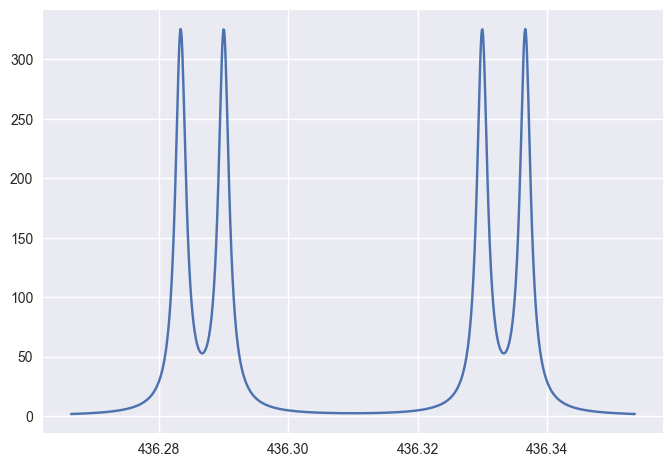

In [301]:
# Now that we have the possible allowable transitions, let's plot them 

print(transitions)
chosen_wavelength = 436.31
xrange = np.linspace(chosen_wavelength*0.9999, chosen_wavelength*1.0001, 1000)
yrange = np.zeros(1000)

for transition in transitions:
    to_add = [intensity_plot(x,0.001, chosen_wavelength+lambda_shift(chosen_wavelength*10**-9,g_eff(three_S_one,three_P_one,transition)*10**9,1.5)) for x in xrange]
    yrange = yrange+to_add

plt.plot(xrange, yrange)

[  2   6  13  45  87 115 118 125 128 130 135 140 143]
[  6  13  45  87 140]
[45 87]
436.31600000000003
[  2   6  13  45  87 115 118 125 128 130 135 140 143]
[  6  13  45  87 140]
[45 87]
436.31600000000003


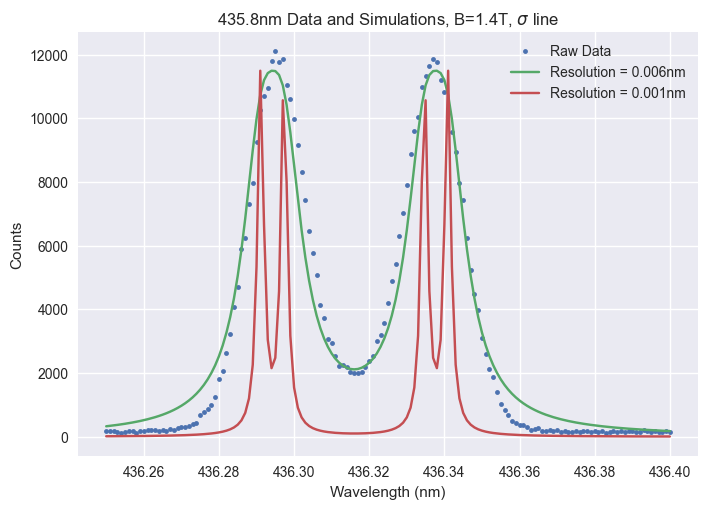

In [364]:
# DEMO ON HOW TO USE THE TOOL

# Step 1: Define your transition in terms of (J, L, S)
three_P_two = (2,1,1)
three_S_one = (1,0,1)

field = 1.4
chosen_wavelength = 435.8
offset = -0.0

res_high = 0.001
res_low = 0.006


sigma_pi = "sigma"
# Step 2: Pick which data point you want to do 
high_field = mercury_data.loc[(f"{chosen_wavelength}nm", "024deg" if sigma_pi=="sigma" else "114deg", f"{field}T"), 'data'][0]

# Step 3: Plot the experimental
plt.plot(high_field["wavelength"], high_field["counts"], '.', label="Raw Data")


# Step 4: Generate simulation fit from theoretical

# PARAMS (experimental x, experimental y, initial state, final state, wavelength, b field, sigma/pi, offset)
plt.title(f"{chosen_wavelength}nm Data and Simulations, B={field}T, $\{sigma_pi}$ line")
x, low_res = generate_plot(high_field["wavelength"], high_field["counts"], three_S_one, three_P_one, chosen_wavelength, field, sigma_pi, res_low, offset)
x, high_res = generate_plot(high_field["wavelength"], high_field["counts"], three_S_one, three_P_one, chosen_wavelength, field, sigma_pi, res_high, offset)

plt.plot(high_field["wavelength"], low_res, label=f"Resolution = {res_low}nm")
plt.plot(high_field["wavelength"], high_res, label=f"Resolution = {res_high}nm")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

plt.legend()

[  3   7  10  62  82 104 153 162 171 177 181 185 189 199]
[ 62 104 171 189 199]
[ 62 104 189 199]
[ 62 104]
546.5830000000001
[  3   7  10  62  82 104 153 162 171 177 181 185 189 199]
[ 62 104 171 189 199]
[ 62 104 189 199]
[ 62 104]
546.5830000000001


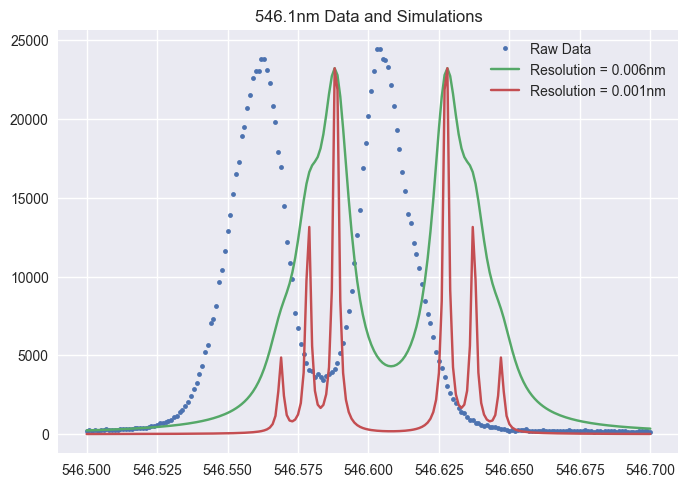

In [303]:


# Step 1: Define your transition in terms of (J, L, S)
three_P_two = (2,1,1)
three_S_one = (1,0,1)


# Step 2: Pick which data point you want to do 
high_field = mercury_data.loc[("546.1nm", "024deg", "1.4T"), 'data'][0]

# Step 3: Plot the experimental
plt.plot(high_field["wavelength"], high_field["counts"], '.', label="Raw Data")


# Step 4: Generate simulation fit from theoretical

# PARAMS (experimental x, experimental y, initial state, final state, wavelength, b field, sigma/pi, offset)

plt.title("546.1nm Data and Simulations")
x, high_res = generate_plot(high_field["wavelength"], high_field["counts"], three_S_one, three_P_two, 546.1, 1.4, "sigma", 0.006, 0.025)
x, low_res = generate_plot(high_field["wavelength"], high_field["counts"], three_S_one, three_P_two, 546.1, 1.4, "sigma", 0.001, 0.025)

plt.plot(high_field["wavelength"], high_res, label="Resolution = 0.006nm")
plt.plot(high_field["wavelength"], low_res, label="Resolution = 0.001nm")

plt.legend()


In [274]:
three_P_zero = (0, 1, 1)

print(provide_allowable_transitions("sigma", three_S_one[0], three_P_zero[0]))

print(provide_allowable_transitions("sigma", three_S_one[0], three_P_one[0]))

for transition in provide_allowable_transitions("sigma", three_S_one[0], three_P_one[0]):
    geff_value = g_eff(three_S_one, three_P_one, transition)
    print(f'Transition: {transition}, g_eff = {geff_value}')

[(-1, 0), (1, 0)]
[(-1, 0), (0, 1), (0, -1), (1, 0)]
Transition: (-1, 0), g_eff = 2.0
Transition: (0, 1), g_eff = 1.5
Transition: (0, -1), g_eff = -1.5
Transition: (1, 0), g_eff = -2.0


In [105]:
print(provide_allowable_transitions("sigma", three_S_one[0], three_P_two[0]))

print(three_P_one)
print(g_lande(three_P_one))

for transition in provide_allowable_transitions("pi", three_S_one[0], three_P_one[0]):
    geff_value = g_eff(three_S_one, three_P_one, transition)
    print(f'{transition[0]}, {transition[1]}, {transition[1]-transition[0]}, $\pi$, {geff_value}?')

[(-1, 0), (-1, -2), (0, 1), (0, -1), (1, 2), (1, 0)]
(1, 1, 1)
1.5
-1, -1, 0, $\pi$, 0.5?
0, 0, 0, $\pi$, 0.0?
1, 1, 0, $\pi$, -0.5?


[0.013999999999953161, 0.021000000000015007]
436.3195
158688736455.77164
1.5743195205223832


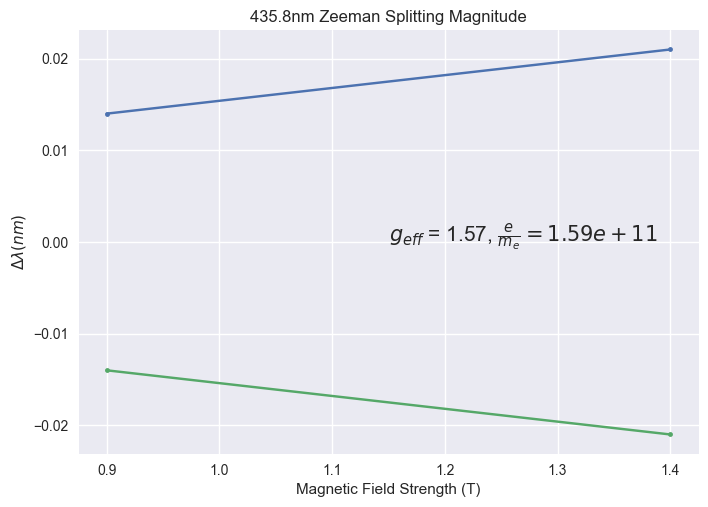

In [394]:
# perform e/m calculation

chosen_wavelength = 435.8

line435 = [mercury_data.loc[(f'{chosen_wavelength}nm', '024deg', '0.9T'), 'data'][0], mercury_data.loc[(f'{chosen_wavelength}nm', '024deg', '1.4T'), 'data'][0]]

b_strength = [0.9, 1.4]
delta_lambda = []
middles = []
for series in line435: 
    current_width = 1
    peaks = find_peaks(np.array(series["counts"]), width =current_width)[0]
    while(len(peaks)>2):
        current_width+=1
        peaks = find_peaks(np.array(series["counts"]), width =current_width)[0]
    peak_wavelength = np.array(series["wavelength"][peaks])
    # Find the wavelength in between 
    middle = np.average(peak_wavelength)
    middles.append(middle)
    this_delta_lambda = middle-peak_wavelength[0]
    delta_lambda.append(this_delta_lambda)
    


print(delta_lambda)

fit = np.polyfit(b_strength, delta_lambda, 1)

slope = fit[0]*10**-9
print(np.average(middles))

ratio = slope*c*4*np.pi/(chosen_wavelength*10**-9)**2/1.75
print(ratio)
g_eff_theorized = slope*h*c/mu_B/(np.average(middles)*10**-9)**2

plt.plot(b_strength, delta_lambda, '.-')
plt.plot(b_strength, -np.array(delta_lambda), '.-')
plt.xlabel("Magnetic Field Strength (T)")
plt.ylabel("$\Delta \lambda (nm)$")
plt.title(f"{chosen_wavelength}nm Zeeman Splitting Magnitude")

plt.text((max(b_strength)-min(b_strength))*0.5+min(b_strength), 0, f"$g_{{eff}}$ = {round(g_eff_theorized,2)}, $\\frac{{e}}{{m_e}} = {ratio:.2e}$", fontsize=15)
print(g_eff_theorized)
